In [1]:
from queries import run_custom_query
from database import add_new_columns, update_stance_categories, update_stance_categories_threshold
import database
import queries

import sys
import json
import jsonlines
import ijson
import pandas as pd

full = "../data/dataset_full_all_fields_v2.jsonl"
public = "../data/dataset_zenodo.jsonl"

In [2]:
# Set file paths
jsonl_file = "../data/dataset_full_all_fields_v2.jsonl"
db_file = "data.db"

# Remove the existing database if necessary
import os
if os.path.exists(db_file):
    os.remove(db_file)

# Recreate the database
conn = database.create_connection(db_file)
database.create_table(conn)

# Load JSONL data into the database
print("Loading data into the database...")
database.load_data(conn, jsonl_file)
print("Data loaded successfully.")

# Close the connection
conn.close()

Loading data into the database...
Finished loading 1524822 lines.
Data loaded successfully.


In [2]:
conn = database.create_connection("data.db")

In [6]:
# Add New Columns
add_new_columns(conn)

Columns added successfully.
Stance categories updated.


In [5]:
# Update Stance Categories
update_stance_categories_threshold(conn, 0.8)

Stance categories updated according to the threshold logic.


In [5]:
df_full = queries.fetch_first_n_rows(conn, n=5)
df_full

,id,tweet_id,author_id,created_at,lang,retweet_count,reply_count,like_count,quote_count,text,...,sentiment,stance,channel,country,verified,follower_count,image_tags,pro_russia,pro_ukraine,unsure
0,1,1540451336876986373,15432891,2022-06-24 21:46:33+00:00,cs,0,0,0,0,Víkendový výber: Zelenská na vojnu nebola prip...,...,"{""neutral"": ""0.5044""}","[{""hypothesis"": ""This statement is in favour o...",denniksme,Slovakia,1,176629,"[""image "", "" poster "", "" rectangle "", "" square...",0,0,1
1,2,1516696238212661253,78567974,2022-04-20 08:32:16+00:00,ro,1,1,0,0,"Guerra Ucraina, Charles Michel a Kiev. Vertice...",...,"{""neutral"": ""0.9146""}","[{""hypothesis"": ""This statement is in favour o...",tempoweb,Italy,0,92093,"[""commuter "", "" couple "", "" crowded "", "" hug ""...",0,0,1
2,3,1587766197298548738,145535271,2022-11-02 11:18:55+00:00,te,0,0,2,0,యుద్ధం లో సరికొత్త అధ్యాయం.. షార్క్ డ్రోన్ ఆవి...,...,"{""neutral"": ""0.5799""}","[{""hypothesis"": ""This statement is in favour o...",TV9Telugu,India,1,569468,[],0,0,1
3,4,1586193152175529984,145535271,2022-10-29 03:08:12+00:00,te,0,0,5,0,అణు యుద్ధం ముంచుకొస్తుందా..? బంకర్లను నిర్మించ...,...,"{""negative"": ""0.79""}","[{""hypothesis"": ""This statement is in favour o...",TV9Telugu,India,1,569468,[],0,0,1
4,5,1580452730212331520,145535271,2022-10-13 06:57:48+00:00,te,0,0,3,0,Boys fight: కోచింగ్ సెంట‌ర్‌లో స్టూడెంట్స్ ఫైట...,...,"{""negative"": ""0.6543""}","[{""hypothesis"": ""This statement is in favour o...",TV9Telugu,India,1,569468,[],0,1,0


In [28]:
# Define the query
query= """
WITH stance_data AS (
    SELECT 
        channel AS Media_Outlet, 
        COUNT(*) AS Tweet_Count,
        SUM(pro_russia) AS Pro_Russia,
        SUM(pro_ukraine) AS Pro_Ukraine,
        SUM(unsure) AS Unsure
    FROM records
    GROUP BY channel
    ORDER BY Tweet_Count DESC
)

SELECT * FROM stance_data;
"""

result = run_custom_query(conn, query)

In [29]:
columns = ["Media Outlet", "Tweet_Count", "Pro_Russia", "Pro_Ukraine", "Unsure"]
df = pd.DataFrame(result, columns=columns)
df

,Media Outlet,Tweet_Count,Pro_Russia,Pro_Ukraine,Unsure
0,AlArabiya,25054,747,2117,23300
1,AlArabiya_Brk,18927,1975,4876,13514
2,kyivindependent,18174,475,1601,17088
3,AJABreaking,16051,732,3729,12633
4,Gordonuacom,15531,701,1201,14275
...,...,...,...,...,...
2074,ABSCBNpr,1,0,0,1
2075,ABSCBN,1,0,0,1
2076,ABCNetwork,1,0,0,1
2077,9xmHaqSe,1,0,0,1


/tmp/ipykernel_3673092/529776519.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Proportion_Pro_Russia"] = (df_filtered["Pro_Russia"] / df_filtered["Tweet_Count"]).round(2)
/tmp/ipykernel_3673092/529776519.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Proportion_Pro_Ukraine"] = (df_filtered["Pro_Ukraine"] / df_filtered["Tweet_Count"]).round(2)
/tmp/ipykernel_3673092/529776519.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

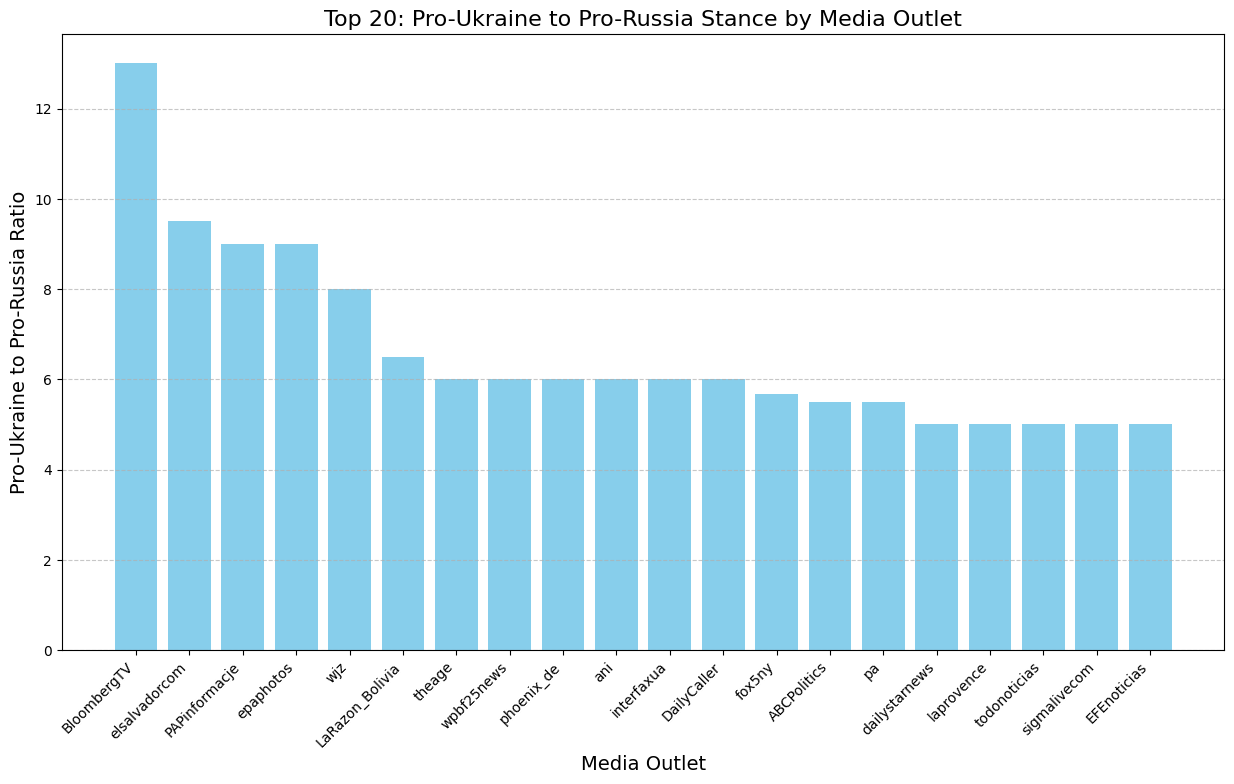

,Media Outlet,Proportion_Pro_Russia,Proportion_Pro_Ukraine,Pro_Ukraine_to_Pro_Russia
384,BloombergTV,0.01,0.13,13.00
429,elsalvadorcom,0.02,0.19,9.50
322,PAPinformacje,0.01,0.09,9.00
419,epaphotos,0.03,0.27,9.00
372,wjz,0.02,0.16,8.00
354,LaRazon_Bolivia,0.02,0.13,6.50
592,theage,0.03,0.18,6.00
425,wpbf25news,0.02,0.12,6.00
221,phoenix_de,0.01,0.06,6.00
153,ani,0.01,0.06,6.00


In [36]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Function to calculate proportions with a minimum pro-Russia + pro-Ukraine tweet count threshold
def calculate_proportions(df, min_combined_count=100):
    df_filtered = df[(df['Pro_Russia'] + df['Pro_Ukraine']) >= min_combined_count]
    df_filtered["Proportion_Pro_Russia"] = (df_filtered["Pro_Russia"] / df_filtered["Tweet_Count"]).round(2)
    df_filtered["Proportion_Pro_Ukraine"] = (df_filtered["Pro_Ukraine"] / df_filtered["Tweet_Count"]).round(2)
    df_filtered["Pro_Ukraine_to_Pro_Russia"] = (df_filtered["Proportion_Pro_Ukraine"] / df_filtered["Proportion_Pro_Russia"]).round(2)
    df_cleaned = df_filtered.dropna(subset=["Pro_Ukraine_to_Pro_Russia"])
    return df_cleaned[df_cleaned["Pro_Ukraine_to_Pro_Russia"].notna()][["Media Outlet", "Proportion_Pro_Russia", "Proportion_Pro_Ukraine", "Pro_Ukraine_to_Pro_Russia"]]

# Function to visualize proportions as a bar plot
def visualize_proportions(df, save_path="../plots/plot_5.png"):
    df = df.dropna(subset=["Pro_Ukraine_to_Pro_Russia"])
    df.sort_values(by='Pro_Ukraine_to_Pro_Russia', ascending=False, inplace=True)
    fig, ax = plt.subplots(figsize=(15, 8))

    # Create bar plot
    ax.bar(df['Media Outlet'], df['Pro_Ukraine_to_Pro_Russia'], color='skyblue')
    ax.set_xlabel('Media Outlet', fontsize=14)
    ax.set_ylabel('Pro-Ukraine to Pro-Russia Ratio', fontsize=14)
    ax.set_title('Top 20: Pro-Ukraine to Pro-Russia Stance by Media Outlet', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


result_df = calculate_proportions(df)
# Sort result_df by descending Pro_Ukraine_to_Pro_Russia value
sorted_df = result_df.sort_values(by='Pro_Ukraine_to_Pro_Russia', ascending=False)
top_20 = sorted_df.head(20)
bottom_20 = sorted_df.tail(20)
visualize_proportions(top_20)
top_20